In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Batch, Data

# Generate DTI
- Data Preprocessing:
    - Filter data for specific drugs (NSC) and genes
    - Convert data to pivot table format
    - Fill missing values with zeros
- Data Visualization:
    - Create histogram showing distribution of non-zero elements per row (drug)
- Data Filtering:
    - Retain only top 1% values for each row, setting others to zero

In [3]:
drug_list = torch.load("../data/drug_list.pt", weights_only=False)

In [4]:
genes = pd.read_csv("../data/genes.csv").T
dti = pd.read_csv("../../DTI-quantification/data/drug_gene_score.csv.gz")
dti = dti[dti.gene.isin(list(genes.index))][["gene", "NSC", "log_Y"]].dropna()
dti = dti[dti.NSC.isin(drug_list)].drop_duplicates()
dti = dti.groupby(["gene", "NSC"]).mean("log_Y").reset_index()
dti

,gene,NSC,log_Y
0,A2M,51148.0,0.590016
1,A2M,93819.0,0.642671
2,A2M,138780.0,0.500000
3,A2M,406472.0,0.500000
4,A2M,732517.0,0.500000
...,...,...,...
51289,ZYX,22842.0,0.552656
51290,ZYX,66357.0,0.500000
51291,ZYX,93819.0,0.590016
51292,ZYX,406472.0,0.500000


In [5]:
len(dti.NSC.unique())

952

In [6]:
len(genes)

5181

In [7]:
drugs = sorted(
    set(pd.read_csv("../data/train_IC50.csv", usecols=["NSC"])["NSC"])
    | set(pd.read_csv("../data/val_IC50.csv", usecols=["NSC"])["NSC"])
    | set(pd.read_csv("../data/test_IC50.csv", usecols=["NSC"])["NSC"])
)
drugs

[186,
 295,
 721,
 740,
 750,
 752,
 755,
 757,
 762,
 844,
 1026,
 1390,
 1895,
 1906,
 2013,
 2654,
 3051,
 3053,
 3088,
 3364,
 3894,
 3905,
 3970,
 4320,
 5889,
 5890,
 6171,
 6175,
 6396,
 6814,
 7521,
 8101,
 8117,
 8120,
 8423,
 8451,
 9168,
 9226,
 9363,
 9364,
 9665,
 9856,
 9908,
 9948,
 11779,
 13119,
 13502,
 13875,
 14666,
 14975,
 15780,
 18334,
 18335,
 18894,
 19492,
 19893,
 19912,
 20256,
 21206,
 21729,
 22842,
 23759,
 24500,
 24559,
 24817,
 24818,
 25154,
 25953,
 26271,
 26980,
 27640,
 28130,
 30706,
 32065,
 32743,
 32946,
 33434,
 33669,
 33832,
 34462,
 35542,
 37364,
 38270,
 38721,
 38876,
 43675,
 45383,
 45388,
 45410,
 49842,
 50256,
 51143,
 51148,
 51355,
 53396,
 58514,
 59729,
 61805,
 63345,
 65104,
 65346,
 66357,
 67574,
 67657,
 68075,
 68928,
 70929,
 73754,
 74859,
 76387,
 76411,
 76557,
 77036,
 77037,
 77213,
 77380,
 79037,
 79389,
 82151,
 83265,
 83628,
 83950,
 85242,
 85442,
 87221,
 88468,
 89201,
 89671,
 91874,
 91994,
 93134,
 93419

In [8]:
set(drugs) - set(dti["NSC"])

set()

In [9]:
print("Unique NSC: ", len(dti.NSC.unique()))
print("Unique gene: ", len(dti.gene.unique()))

Unique NSC:  952
Unique gene:  4983


In [10]:
pivot = dti.pivot(index="NSC", columns="gene", values="log_Y")
pivot.index = list([int(i) for i in pivot.index])
pivot.columns = list(pivot.columns)
pivot = pivot.fillna(0)
pivot

,A2M,AAAS,AACS,AAK1,AAR2,AARS2,AASDH,AASDHPPT,AATF,ABAT,...,ZNF692,ZNF789,ZNF804B,ZNF84,ZNF93,ZRANB1,ZRANB3,ZWILCH,ZWINT,ZYX
186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
809693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
813783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0


In [12]:
df = pd.DataFrame(0.0, columns=list(genes.index), index=drug_list)
df.update(pivot)
df

,A2M,AAAS,AACS,AAK1,AAR2,AARS2,AASDH,AASDHPPT,AATF,ABAT,...,ZNF746,ZNF789,ZNF804B,ZNF84,ZNF93,ZRANB1,ZRANB3,ZWILCH,ZWINT,ZYX
186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
809693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
813783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0


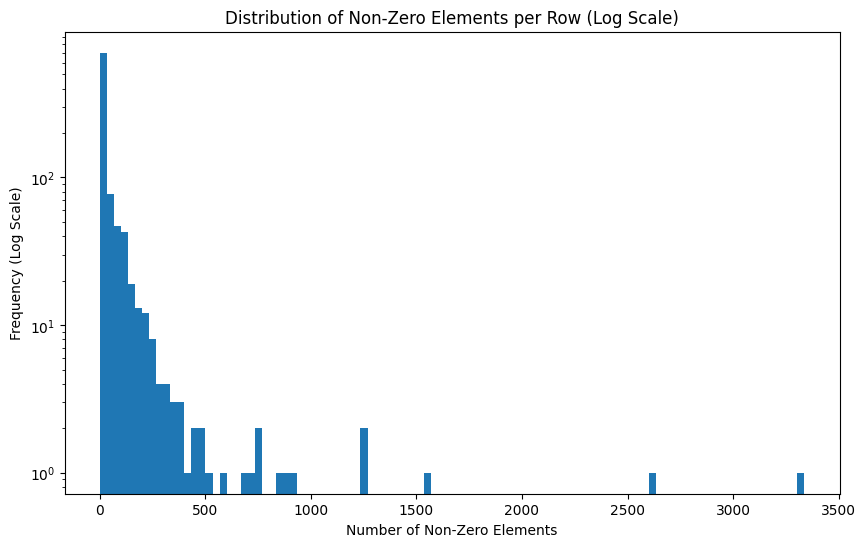

In [13]:
tmp = np.sum(np.sign(df), axis=1)
plt.figure(figsize=(10, 6))
tmp.plot.hist(bins=100)

# y軸を対数スケールに設定
plt.yscale("log")

# グラフにタイトルと軸ラベルを追加
plt.title("Distribution of Non-Zero Elements per Row (Log Scale)")
plt.xlabel("Number of Non-Zero Elements")
plt.ylabel("Frequency (Log Scale)")

# グラフを表示
plt.show()

In [21]:
def keep_top_1_percent(row):
    n = int(len(row) * 0.01)
    threshold = sorted(row, reverse=True)[n - 1]  # n番目に大きい値
    return np.where(row >= threshold, row, 0)


# 関数を適用（データフレームの構造を保持）
df_filtered = df.apply(
    lambda row: pd.Series(keep_top_1_percent(row), index=df.columns), axis=1
)

In [22]:
df_filtered

,A2M,AAAS,AACS,AAK1,AAR2,AARS2,AASDH,AASDHPPT,AATF,ABAT,...,ZNF746,ZNF789,ZNF804B,ZNF84,ZNF93,ZRANB1,ZRANB3,ZWILCH,ZWINT,ZYX
186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
809693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
813783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0


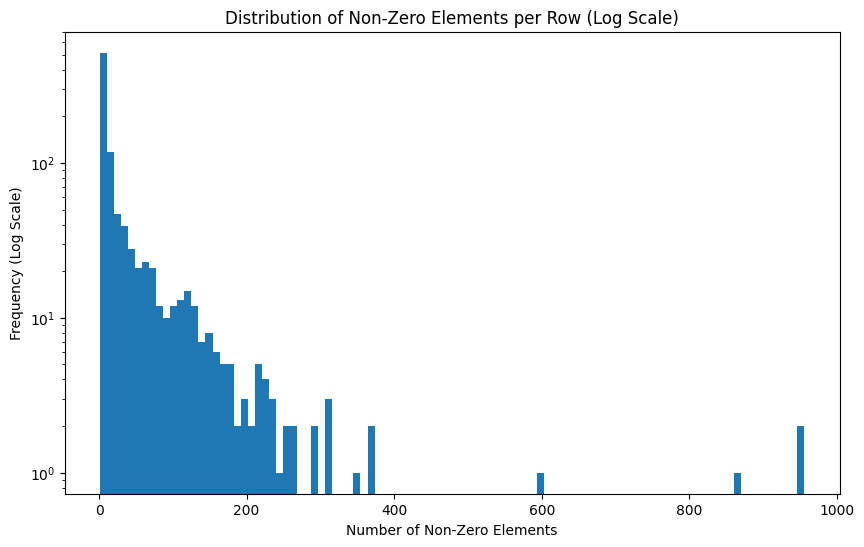

In [23]:
tmp = np.sum(np.sign(df_filtered), axis=1)
plt.figure(figsize=(10, 6))
tmp.plot.hist(bins=100)

# y軸を対数スケールに設定
plt.yscale("log")

# グラフにタイトルと軸ラベルを追加
plt.title("Distribution of Non-Zero Elements per Row (Log Scale)")
plt.xlabel("Number of Non-Zero Elements")
plt.ylabel("Frequency (Log Scale)")

# グラフを表示
plt.show()

In [24]:
df_filtered

,A2M,AAAS,AACS,AAK1,AAR2,AARS2,AASDH,AASDHPPT,AATF,ABAT,...,ZNF746,ZNF789,ZNF804B,ZNF84,ZNF93,ZRANB1,ZRANB3,ZWILCH,ZWINT,ZYX
186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
809693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
813783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0


In [25]:
df_filtered.to_csv("../data/dti.csv.gz", compression="gzip")